In [8]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

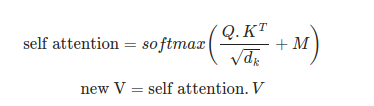
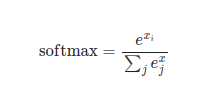


In [82]:
def scaled_dot_product(q,k,v, mask= None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q,k.transpose(-1,-2) / math.sqrt(d_k))
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim = -1)
    values = torch.matmul(attention, v)
    return values, attention



In [52]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, sequence_length, d_model = x.size()
        qkv = self.qkv_layer(x) 
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim) 
        qkv = qkv.permute(0, 2, 1, 3) 
        q, k, v = qkv.chunk(3, dim=-1)
        values, attention = scaled_dot_product(q, k, v, mask) 
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim) 
        out = self.linear_layer(values) 
        return out 

In [81]:
class MultiHeadCrossAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model , 2 * d_model) 
        self.q_layer = nn.Linear(d_model , d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, y, mask=None):
        batch_size, sequence_length, d_model = x.size() 
        kv = self.kv_layer(x) 
        q = self.q_layer(y)
        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim)  
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim)  
        kv = kv.permute(0, 2, 1, 3) 
        q = q.permute(0, 2, 1, 3) 
        k, v = kv.chunk(2, dim=-1)
        values, attention = scaled_dot_product(q, k, v, mask)
        values = values.reshape(batch_size, sequence_length, d_model) 
        out = self.linear_layer(values)  
        return out  

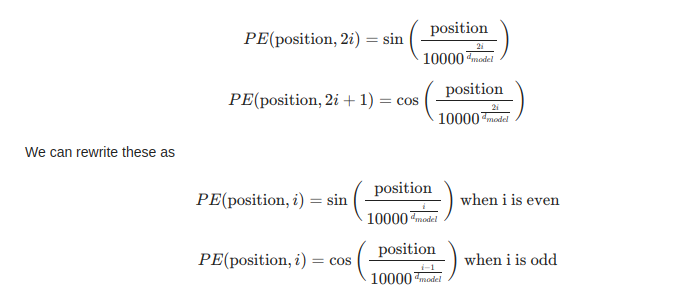

In [72]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        slf.d_model = d_model
        
        
    def forward(self):
        even_i = torch.arrange(0,self.d_model,2).float()
        #two denominators come out to be the same
        denominator = torch.pow(10000, even_i/self.d_model)
        position = torch.arange(self.max_sequence_length).reshape(self.max_sequence_length, 1)
        even_PE = torch.sin(position/denominator)
        odd = torch.cos(position/denominator)
        stacked = torch.stack([even_PE , odd_PE], dim = 2)
        PE = torch.flatten(stackerd, star_dim = 1, end_dim = 2)
        return PE

In [73]:
class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape)) 

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim=dims, keepdim=True) 
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True) 
        std = (var + self.eps).sqrt() 
        y = (inputs - mean) / std
        out = self.gamma * y  + self.beta  
        return out

In [74]:
class PositionwiseFeedForward(nn.Module):
    
    def __init__(self, d_model, hidden, drop_prob = 0.2):
        super(PositionwiseFeedForward , self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [87]:
class EncoderLayer(nn.Module):
    
    def __init__(self, d_model, ffn_hidden , num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)
        
    
    def forward(self, x):
        residual_x = x
        x = self.attention(x, mask = None)
        x = self.dropout1(x)
        x = self.norm1(x+ residual_x)
        residual_x = x
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x+residual_x)
        return x

In [76]:
class Encoder(nn.Module):
    
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers):
        super().__init__()
        self.layers = nn.Sequential(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob) for _ in range(num_layers)])
     
    
    def forward(self, x):
        x = self.layers(x)
        return x
        

In [77]:
class DecoderLayer(nn.Module):
    
    def __init__(self, d_model, ffn_hidden , num_heads, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.encoder_decoder_attention = MultiHeadCrossAttention(d_model=d_model, num_heads=num_heads)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm3 = LayerNormalization(parameters_shape=[d_model])
        self.dropout3 = nn.Dropout(p=drop_prob)
        
    
    def forward(self, x, y, decoder_mask):
        _y = y 
        y = self.self_attention(y, mask=decoder_mask)
        y = self.dropout1(y) 
        y = self.norm1(y + _y) 

        _y = y
        y = self.encoder_decoder_attention(x, y, mask=None) 
        y = self.dropout2(y)
        y = self.norm2(y + _y) 

        _y = y 
        y = self.ffn(y) 
        y = self.dropout3(y)
        y = self.norm3(y + _y)
        return y 

In [78]:
class SequentialDecoder(nn.Sequential):
    
    def forward(self, *inputs):
        x, y, mask = inputs
        for module in self._modules.values():
            y = module(x,y,mask)
        return y

In [79]:
class Decoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers=1):
        super().__init__()
        self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob) 
                                          for _ in range(num_layers)])

    def forward(self, x, y, mask):
        y = self.layers(x, y, mask)
        return y 

In [88]:
d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 30
max_sequence_length = 200
ffn_hidden = 2048
num_layers = 5

encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers)
     


In [89]:
x = torch.randn( (batch_size, max_sequence_length, d_model) ) 
out = encoder(x)

In [90]:
out

tensor([[[ 1.1550,  0.5563, -2.0342,  ...,  2.3854,  0.8015,  1.0733],
         [ 0.1587,  0.3971,  0.3725,  ..., -0.7986,  0.4486, -0.8283],
         [-1.0117,  0.4729, -0.3611,  ...,  0.1265, -0.5430, -0.2527],
         ...,
         [-0.2195, -0.0601,  1.8367,  ...,  1.0882, -1.1751,  0.8085],
         [-0.1852,  3.0731,  1.3176,  ..., -0.2631,  0.3160,  1.2113],
         [-0.3202, -1.1479,  1.1487,  ..., -1.1827,  1.4146, -0.2663]],

        [[ 1.3328,  1.3638,  0.9223,  ...,  0.3814, -0.3832,  0.1147],
         [ 0.6753, -0.5421,  1.0374,  ...,  0.1504,  0.0239, -1.7658],
         [ 0.5386,  0.4953, -1.0074,  ..., -0.8961, -1.4070, -0.4520],
         ...,
         [ 0.8801,  0.8917, -0.5492,  ..., -1.0383, -0.3882, -0.0925],
         [-0.7509, -0.1576,  0.6109,  ..., -0.9872,  0.2593, -0.4349],
         [ 0.2413, -0.9924,  0.7224,  ..., -0.5430,  0.6087, -0.0719]],

        [[ 0.5002, -0.5212,  1.7357,  ...,  0.0858, -1.0845,  0.1132],
         [ 0.0035,  1.1161, -1.5188,  ...,  1

In [83]:

d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 30
max_sequence_length = 200
ffn_hidden = 2048
num_layers = 5

x = torch.randn( (batch_size, max_sequence_length, d_model) ) # English sentence positional encoded 
y = torch.randn( (batch_size, max_sequence_length, d_model) ) # Kannada sentence positional encoded 
mask = torch.full([max_sequence_length, max_sequence_length] , float('-inf'))
mask = torch.triu(mask, diagonal=1)
decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers)
out = decoder(x, y, mask)

In [84]:
out

tensor([[[ 0.6420,  0.1580,  0.5143,  ...,  0.7553,  0.6989,  0.5001],
         [-0.6353, -0.7939,  1.3808,  ..., -1.0620, -0.7150,  0.7453],
         [ 0.8221,  0.8300, -0.6012,  ..., -0.2849,  0.2927, -0.8709],
         ...,
         [ 0.3115, -1.5143,  0.7118,  ..., -0.1685,  1.7310,  1.7212],
         [ 0.2028, -0.9611, -0.1200,  ...,  0.7483,  0.5921, -1.5894],
         [-1.3732, -0.7969,  0.5569,  ..., -0.9016, -2.0629,  1.1437]],

        [[ 0.9750, -0.0035,  1.1935,  ...,  0.0421,  0.2394, -0.2504],
         [-0.0769, -0.6086, -0.1997,  ...,  1.1507,  1.3280, -0.0715],
         [ 0.3256,  0.1267, -0.4681,  ..., -1.0778, -0.9462, -1.2341],
         ...,
         [ 0.2574,  0.0064,  1.8584,  ..., -0.3822,  0.1715,  0.3847],
         [-0.1998,  0.1682,  1.8478,  ..., -2.2575,  0.0957,  1.1827],
         [ 2.6279, -1.3257,  0.8933,  ...,  0.8676,  1.2999, -1.6011]],

        [[ 0.4425, -0.0322,  0.0227,  ..., -0.8423, -1.6492, -1.1281],
         [ 0.8561,  0.3477,  0.3383,  ...,  0